In [1]:
from utils.config import Project_Config, CIFAR_10_Config, CIFAR_10_Local_Config, Model_Config
from utils.custom_enums import Dataset_Type_Enum, Model_Type_Enum
project_config = Project_Config()

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [2]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from os import makedirs

In [3]:
dataset_type = Dataset_Type_Enum.CIFAR10
SAVE=True
weight_dtype = torch.float32


f = project_config.folder_symbol
save_dir_path = (
    project_config.PWD + f +
    "VAE" + f
)

save_file_path = (
    save_dir_path + f +
    f"vae-{dataset_type}.pt"
)

In [4]:
model_type = Model_Type_Enum.FULL
model_config = Model_Config(
    project_config=project_config,
    MODEL_TYPE=model_type,
    DATASET_TYPE=dataset_type,
    NUM_CHECKPOINTS=10, 
    ITERATIONS_PER_CHECKPOINT=1000
)

In [5]:
if dataset_type == Dataset_Type_Enum.CIFAR2:
    dataset_config = CIFAR_10_Local_Config(
        project_config=project_config,
        dataset_type=dataset_type
    )
if dataset_type == Dataset_Type_Enum.CIFAR10:
    dataset_config = CIFAR_10_Config()

In [6]:
dataset_config.dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'label_txt': Value(dtype='string', id=None)}

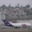

In [7]:
dataset_config.dataset[0]["image"]

In [8]:
dataset_config.dataset[0]["label_txt"]

'airplane'

In [9]:
p = model_config.getModelDirectory()
tokenizer, _, vae, _ = model_config.loadModelComponents(p)

if project_config.IS_CUDA:
    vae.to("cuda")

vae.requires_grad_(False)
print("") #Stop ipynb from dumping the full VAE description after this block

In [10]:
train_dataset = dataset_config.preprocess(tokenizer)

dataset_length = len(train_dataset)

# DataLoaders creation:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=False,
    collate_fn=dataset_config.collate_fn,
    batch_size=1,
)

In [11]:
if SAVE:
    #NOTE: latent size is hard coded for SD1, you will need to change this for other models
    precomputed_latents_matrix = torch.zeros(dataset_length,4,4,4,device="cpu")

    if project_config.IS_CUDA:
        #GPU side buffer to avoid copying to RAM every iteration
        GPU_BUFFER_SIZE = 1000
        latents_buffer = torch.zeros(GPU_BUFFER_SIZE,4,4,4,device="cuda")

    #iterator for the latent buffer
    i = 0 
    #iterator for the buffers to full matrix
    j = 0
    for batch in tqdm(train_dataloader):
        if project_config.IS_CUDA:
            batch = [x.cuda() for y,x in batch.items()]
        else:
            batch = [x for y,x in batch.items()]
        image = batch[0]
        tokens = batch[1]
        # Convert images to latent space
        latents = vae.encode(image.to(weight_dtype)).latent_dist.sample()
        latents = latents * vae.config.scaling_factor
        if project_config.IS_CUDA:
            latents_buffer[i] = latents
            i+=1
            if i==GPU_BUFFER_SIZE:
                precomputed_latents_matrix[j:(j+GPU_BUFFER_SIZE)] = latents_buffer.detach().cpu()
                latents_buffer = torch.zeros_like(latents_buffer)
                j+=GPU_BUFFER_SIZE
                i=0
        else:
            precomputed_latents_matrix[i]=latents
            i+=1

100%|██████████| 50000/50000 [03:01<00:00, 275.61it/s]


In [12]:
if SAVE:
    print(list(precomputed_latents_matrix.shape))
    print(precomputed_latents_matrix[0])

[50000, 4, 4, 4]
tensor([[[ 2.8180e-01, -1.0370e-01, -6.8682e-01, -3.0771e-01],
         [ 3.9340e-01, -4.2729e-01, -1.4128e-01, -6.5459e-01],
         [-1.4997e-01, -8.6170e-01,  9.7968e-01,  1.0312e+00],
         [ 1.1776e-01,  7.1766e-01, -6.0843e-01, -4.6587e-01]],

        [[ 9.4966e-01,  6.0608e-01,  1.2866e+00,  1.0569e+00],
         [-9.5986e-01, -4.6757e-01, -3.5567e-01, -2.8755e-01],
         [ 1.4103e-01, -8.4009e-01, -5.5975e-01, -3.1648e-01],
         [-5.3724e-01,  2.4471e-01,  3.8255e-01,  4.0280e-01]],

        [[ 5.4163e-01, -6.1474e-01,  5.1969e-02, -1.2104e+00],
         [-7.7455e-02,  4.5337e-01,  5.0793e-01,  3.7314e-01],
         [ 1.1228e+00, -6.4420e-01,  4.6458e-01, -1.6711e-01],
         [-2.4756e-01, -6.2453e-01, -9.7129e-01, -1.1437e+00]],

        [[ 6.4098e-04, -1.0270e+00, -9.8081e-01, -9.0646e-01],
         [-1.2949e-01, -2.9597e-01, -1.3314e-01, -2.4591e-01],
         [ 7.1650e-01, -1.3980e+00,  3.0067e-02, -1.2232e-02],
         [-3.5809e-01,  9.1187e-

In [13]:
if SAVE:
    makedirs(save_dir_path, exist_ok=True)

    torch.save(precomputed_latents_matrix, save_file_path)

In [14]:
pregenerated_vae_results = torch.load(save_file_path)
print(list(pregenerated_vae_results.shape))

pregenerated_vae_results = pregenerated_vae_results.reshape(dataset_length,4*4*4)

[50000, 4, 4, 4]


/tmp/ipykernel_455006/2299741129.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pregenerated_vae_results = torch.load(save_file_path)


In [15]:
target_index = 100

for index, batch in enumerate(train_dataloader):
    if index == target_index:
        example_batch = batch
        break

if project_config.IS_CUDA:
    example_batch = [x.cuda() for y,x in example_batch.items()]
else:
    example_batch = [x for y,x in example_batch.items()]
image = example_batch[0]
# Convert images to latent space
latents = vae.encode(image.to(weight_dtype)).latent_dist.sample()
latents = latents * vae.config.scaling_factor

latents = latents.reshape(1,4*4*4)
if project_config.IS_CUDA:
    latents = latents.detach().cpu()
print(latents.shape)
print(pregenerated_vae_results.shape)

cosine_similarity = torch.nn.CosineSimilarity(dim=1)

c = torch.zeros(1,dataset_length)

set_size = 1000

for i in range(0,dataset_length//set_size):
    a=i*set_size
    b=(i+1)*set_size

    c[0,a:b] = cosine_similarity(latents,pregenerated_vae_results[a:b])

print(c.shape)
print(c)
print(torch.argmax(c))

torch.Size([1, 64])
torch.Size([50000, 64])
torch.Size([1, 50000])
tensor([[-0.3351,  0.1757,  0.2333,  ...,  0.1162,  0.0247,  0.0050]])
tensor(100)


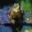

frog


In [18]:
image = dataset_config.dataset[100]["image"]
display(image)
print(dataset_config.dataset[100]["label_txt"])

tensor([  100, 31148, 31282, 10783, 36939, 20294, 20160, 25913, 30282, 48341])


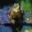

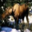

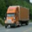

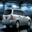

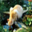

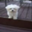

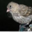

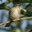

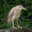

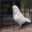

In [17]:
best_matches = torch.flatten(torch.topk(c,10).indices)
print(best_matches)

for i in range(10):
    display(dataset_config.dataset["image"][best_matches[i]])